<a href="https://colab.research.google.com/github/mahdi943/Inceptionv3-hierarchical/blob/master/Acc_72_Training_brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
from numpy import random

import keras
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, BatchNormalization,Activation, Flatten, GlobalAveragePooling2D, SeparableConv2D
from keras.models import Model

from keras.preprocessing import image
from keras.utils import layer_utils
from keras.layers import Dropout
from keras.regularizers import l2
from keras.regularizers import l1
np.random.seed(5)
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import cv2
import os
from keras.utils.np_utils import to_categorical
from PIL import Image
from keras.preprocessing.image import load_img,img_to_array,array_to_img,save_img

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/project/dataset/labelTrain1.csv') # enter the file path on your drive for the csv file
data.head()

,Image,Class0,Class1
0,1.jpg,1,0
1,2.jpg,1,0
2,3.jpg,1,0
3,4.jpg,1,0
4,5.jpg,1,0


In [ ]:
from keras.applications import inception_v3
from keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape=(500, 500, 3))
base_model.layers.pop()
base_model.layers.pop()
base_model.layers.pop()
base_model.layers.pop()
for layer in base_model.layers:
  layer.trainable = False
# base_model.summary()

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
def brain_model(base_model, img_shape = (500,500,3)):
    
    
    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=img_shape) 
    
    # Forward pass to get the output of the last pooling layer
    X = base_model(inputs)
    #X = Dropout(.5, img_shape)(X)
    X = GlobalAveragePooling2D()(X)
    X = Dropout(.25)(X)
    # Define the new binary classification head 
    
    X = Dense(1024, activation='relu', name='fc1')(X)
    X = Dropout(.5)(X)
    # X = Dense(512, activation='relu', name='fc2')(X)
    # X = Dropout(.25)(X)
    X = Dense(256, activation='relu', name='fc3')(X)
    X = Dropout(.5)(X)
    # X = Dense(128, activation='relu', name='fc4')(X)
    # X = Dropout(.25)(X)
    X = Dense(64, activation='relu', name='fc5')(X)
    X = Dropout(.5)(X)
        
    outputs = Dense(2,activation='softmax', name='predictions')(X)
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [ ]:
#Create your model using the function above

model = brain_model (base_model, img_shape = (500,500,3))

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_11 (Dropout)        (None, 2048)              0         
                                                                 
 fc1 (Dense)                 (None, 1024)              2098176   
                                                                 
 dropout_12 (Dropout)        (None, 1024)              0         
                                                           

## 7) Train the Network with  Tuned Parameters

In [ ]:
data1 = pd.read_csv('/content/drive/MyDrive/project/dataset/labelValid1.csv') # enter the file path on your drive for the csv file
data1.head()

,Image,Class0,Class1
0,65.jpg,1,0
1,66.jpg,1,0
2,67.jpg,1,0
3,68.jpg,1,0
4,69.jpg,1,0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/project/dataset/Train.zip"

In [ ]:
y_col = ['Class0', 'Class1']

In [ ]:
batch_size = 16
#FOLDER_PATH = Enter the path of the folder that contains images
data_path = "/content/Train" #where you extracted the zip file

#Should augmentations be the same for training and validation? 
#train_aug = ImageDataGenerator(rescale=1./255, ...)
#valid_aug = ImageDataGenerator(rescale=1./255, ...)

#shuffle the data
data = data.sample(frac=1)
data.reset_index(drop = True, inplace = True)

train_aug = ImageDataGenerator(rescale=1./255, 
                              #  width_shift_range=[-100,100], 
                              #  height_shift_range=0.5,       
                               shear_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               rotation_range=90,
                               brightness_range=[0.2,0.05],
                               zoom_range=0.2
                               )

# train_aug = ImageDataGenerator(rescale=1./255,         
#                                shear_range=0.2,
#                                zoom_range=0.2,
#                                horizontal_flip=False)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_aug = ImageDataGenerator(rescale=1./255)

train_generator = train_aug.flow_from_dataframe(
    dataframe=data,
    directory=data_path,
    x_col='Image',
    y_col= y_col,
    class_mode="raw",
    target_size=(500,500), #this will resize the image, you can change the size
    batch_size=batch_size)




Found 256 validated image filenames.


In [ ]:
# cd C:/Users/Asus/Downloads/cropped images/Valid

C:\Users\Asus\Downloads\cropped images\Valid


In [ ]:
!unzip "/content/drive/MyDrive/project/dataset/Valid.zip"

In [ ]:
valid_generator = test_aug.flow_from_dataframe(
    dataframe=data1,
    directory="/content/Valid",
    x_col='Image',
    y_col= y_col,
    class_mode= "raw",
    target_size=(500,500), #this will resize the image, you can change the size
    batch_size=batch_size
)

Found 64 validated image filenames.


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, batch_size= 16 ,epochs=20, validation_data = valid_generator, callbacks= callback)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
16/16 [==============================] - 23s 1s/step - loss: 0.8149 - accuracy: 0.6680 - val_loss: 0.5561 - val_accuracy: 0.7500
Epoch 2/20
16/16 [==============================] - 18s 1s/step - loss: 0.7636 - accuracy: 0.7148 - val_loss: 0.5012 - val_accuracy: 0.7500
Epoch 3/20
16/16 [==============================] - 18s 1s/step - loss: 0.5555 - accuracy: 0.7656 - val_loss: 0.4603 - val_accuracy: 0.8906
Epoch 4/20
16/16 [==============================] - 18s 1s/step - loss: 0.4546 - accuracy: 0.8203 - val_loss: 0.3826 - val_accuracy: 0.7500
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 0.3898 - accuracy: 0.8242 - val_loss: 0.3389 - val_accuracy: 0.8906
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 0.3354 - accuracy: 0.8477 - val_loss: 0.3064 - val_accuracy: 0.8906
Epoch 7/20
16/16 [==============================] - 18s 1s/step - loss: 0.2970 - accuracy: 0.8750 - val_loss: 0.3144 - val_accuracy: 0.8281
Epoch 8/20
16/16 [==

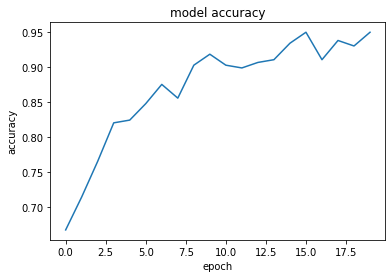

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['8', '16', '32', '128'], loc='upper left')
plt.savefig('Q1_multi.jpg')
plt.show()

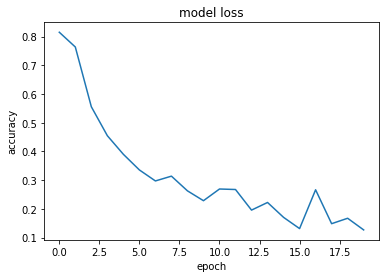

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['8', '16', '32', '128'], loc='upper left')
plt.savefig('Q1_multi.jpg')
plt.show()

In [ ]:
!unzip "/content/drive/MyDrive/project/dataset/Test.zip"
data2 = pd.read_csv('/content/drive/MyDrive/project/dataset/labelTest1.csv') # enter the file path on your drive for the csv file
data2.head()

In [ ]:
test_generator = test_aug.flow_from_dataframe(
    dataframe=data2,
    directory="/content/Test",
    x_col='Image',
    y_col= y_col,
    class_mode= "raw",
    target_size=(500,500), #this will resize the image, you can change the size
    batch_size=batch_size
)

Found 80 validated image filenames.


In [ ]:
from sklearn.metrics import accuracy_score
# Load test data
import csv 
from sklearn import metrics

data3 = pd.read_csv('/content/drive/MyDrive/project/dataset/labelTestfinal.csv') # enter the file path on your drive for the csv file
data3.head()

y_predict = model.predict(test_generator)

y_predict = y_predict.argmax(-1)
accuracy_score(data3['label'],y_predict)
    


0.725